Let's go through what's necessary for the calculation of the thermal conductivity for any given time step during the TRT at specific locations:

In [1]:
%matplotlib inline

1. Read in the existing dataset: $T_s,T_r,Watts,t$, from the trt dataset
2. Find the gradient of temperature (whichever should be fine) to the natural log of hours, so your $m = \frac{dT}{d ln(t)}$
3. Using the gradient of the temperature, it is already possible to estimate the thermal conductivity, using $k_s = \frac{Q}{4\pi m}$
4. The thermal diffusivity can then be evaluated at $\alpha_s = \frac{k_s}{c_p}$,where the heat capacity is a known value: 37.5 in IP units
5. The borehole resistence may therefore be calculated as 
$R_b = \frac{1}{4\pi k_s}$ $(\frac{T_m - T_{rs}}{m}-ln\frac{4\alpha_s t}{r_b^2})$

The question then becomes... how do we evaluate the thermal conductivity at different depths of the well? It actually is pretty simple - we just need to use a few of the further simplifications that we've already seen.

If I remember correctly, the first thing we want to do is to slice the existing data to a dataframe that has all the information we want/need:
1. Find the time stamps we're looking for
2. Combine and convert the existing files into ones that has the following columns: annulus, grout, **CONSISTENT** time, and corresponding heat injection rates
_Note this will be problematic because we have four-minute-intervals while the other have five-minute ones... but nonetheless this is a key step to complete, and we can call quit today once this is achieved._
3. Calculate $R_{b,g}$
4. Calculate the corresponding $k_{s,i}$ using the equation on notebook

### Measurement Time
Start - Sep, 10th, 17:40:50 

End - Sep, 12th, 18:10:00

In [363]:
#Now let's try to process these folders/file data
import matplotlib.pyplot as plt

In [364]:
import pandas as pd
import os
from glob import glob

In [365]:
ts = glob('pt0920/channel 1/2019/sep/*00001.ddf')

In [366]:
ts.sort()

In [367]:
ts[-1]>ts[0]

True

In [368]:
s1 = 'pt0920/channel 1/2019/sep/'
s2 = 'pt0920/channel 2/2019/sep/'
s3 = 'pt0920/channel 3/2019/sep/'
s4 = 'pt0920/channel 4/2019/sep/'
s0 = '*00001.ddf'
s = [s0,s1,s2,s3,s4]

In [370]:
import bisect
fl = []
for i in s[1:]:
    fi = glob(i+s0)
    fi.sort()
    ref1 = i + i[7:16] + ' 20190910 174000' + s0[1:]
    ref2 = i + i[7:16] + ' 20190912 181000' + s0[1:]
    fin = fi[bisect.bisect_right(fi,ref1):]
    fnn = fin[:bisect.bisect_left(fin,ref2)]
    fl.append(fnn)
    print i+s0

pt0920/channel 1/2019/sep/*00001.ddf
pt0920/channel 2/2019/sep/*00001.ddf
pt0920/channel 3/2019/sep/*00001.ddf
pt0920/channel 4/2019/sep/*00001.ddf


So, good news is we now have fl as the names of the files that we want to harvest, so we do have things in order. Now that's assemble the csvs together. 

Note that Channel 1, 3 are inner duplicates, 2,4 are outer duplicates.

In [371]:
for i in range(4):
    print len(fl[i])
    
#We're working only C3 and C4 for now since they happen to ...! have consistent lengths.

715
696
686
691


In [373]:
import pickle
with open('ins','rb') as f:
    inss = pickle.load(f)
insf = ['%.3f' % elem for elem in inss]

In [374]:
f23 = fl[2]
all3 = pd.DataFrame()
for i in range(len(f23)):
    fram = pd.read_csv(f23[i],header=25,sep='\t')
    fram.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True)
    DF = fram[fram['depth']>0]
    DF = DF.set_index('depth')
    DF = DF.transpose()
    s = DF.iloc[0].astype(float)
    s.name = str(f23[i])[-25:-25+8]+str(f23[i])[-25+9:-25+15]
#     print s
    all3 = all3.append(s)

In [418]:
f24 = fl[3]
all4 = pd.DataFrame()
for i in range(len(f24)):Hongshan Guo
    fram = pd.read_csv(f24[i],header=25,sep='\t')
    fram.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True)
    DF = fram[fram['depth']>0]
    DF = DF.set_index('depth')
    DF = DF.transpose()
    s = DF.iloc[0].astype(float)
    s.name = str(f24[i])[-25:-25+8]+str(f24[i])[-25+9:-25+15]
#     print s
    all4 = all4.append(s)

In [216]:
Hongshan Guoall3.describe()

,0.556,1.571,2.586,3.6,4.615,5.629,6.644,7.659,8.673,9.688,...,413.496,414.511,415.526,416.54,417.555,418.569,419.584,420.599,421.613,422.628
count,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,...,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,34.178595,31.314465,27.825373,26.130101,24.631875,20.824929,10.591738,2.478055,1.298657,1.089520,...,25.939061,26.026118,26.030741,26.005806,25.946321,25.680781,25.619424,25.707633,124.672972,107.514729
std,5.232315,5.259066,5.102314,4.937556,4.642868,3.692393,2.359654,1.795329,1.782961,1.763852,...,3.103324,3.111285,3.111018,3.108597,3.102379,3.099326,3.100759,3.103864,28.160610,24.739205
min,26.679000,23.868000,20.558000,19.064000,18.042000,15.589000,7.399000,0.676000,-0.290000,-0.449000,...,18.426000,18.397000,18.213000,18.340000,18.194000,17.978000,18.067000,18.192000,82.851000,70.174000
25%,29.683000,26.714500,23.193000,21.574750,20.455500,17.622750,8.586000,1.117500,-0.047500,-0.225000,...,23.638500,23.769750,23.751750,23.706500,23.628750,23.368000,23.328000,23.396250,101.249500,87.175750
50%,33.662000,30.857000,27.599500,25.912000,24.488500,20.750000,10.898500,2.756500,1.400000,1.141000,...,26.453000,26.532000,26.558500,26.496000,26.428500,26.235000,26.129500,26.238000,110.792000,95.556500
75%,38.365250,35.400500,31.402750,29.519750,27.698000,22.954000,11.686000,3.295250,2.218500,1.959500,...,28.109000,28.205500,28.199250,28.168750,28.117250,27.847000,27.798250,27.878750,156.770000,135.513250
max,55.454000,52.672000,49.517000,47.790000,45.919000,41.231000,29.868000,21.246000,20.091000,19.909000,...,48.443000,48.457000,48.570000,48.565000,48.470000,48.109000,48.021000,48.239000,206.913000,181.287000


In [217]:
all4.describe()

,0.556,1.571,2.586,3.6,4.615,5.629,6.644,7.659,8.673,9.688,...,413.496,414.511,415.526,416.54,417.555,418.569,419.584,420.599,421.613,422.628
count,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,...,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000,691.000000
mean,34.117750,29.991329,25.992732,24.904197,24.277463,18.326890,7.363437,1.655615,1.181797,1.125069,...,27.443333,27.441618,27.465220,27.462609,27.463016,27.461728,27.470784,27.495887,108.324543,107.038588
std,5.228377,5.178482,4.948807,4.771881,4.441682,3.346299,2.042650,1.708030,1.705572,1.706280,...,3.118467,3.122902,3.118113,3.116252,3.122480,3.121426,3.117546,3.122312,25.990536,24.396063
min,26.618000,22.554000,18.820000,17.920000,17.773000,13.607000,4.764000,0.056000,-0.353000,-0.421000,...,19.613000,19.578000,19.623000,19.644000,19.681000,19.653000,19.651000,19.613000,68.948000,69.651000
25%,29.636000,25.417000,21.548000,20.509000,20.252500,15.500500,5.737500,0.299500,-0.176000,-0.222500,...,25.150000,25.192500,25.180000,25.166500,25.145500,25.182000,25.193500,25.201000,87.960000,88.121000
50%,33.609000,29.664000,25.854000,24.781000,24.129000,18.370000,7.843000,1.924000,1.282000,1.189000,...,28.022000,27.993000,28.021000,28.019000,27.997000,27.992000,28.002000,27.993000,95.310000,94.827000
75%,38.171000,33.929000,29.561500,28.272500,27.244000,20.345000,8.452500,2.514500,2.047000,2.006000,...,29.625000,29.613000,29.629000,29.656000,29.638000,29.658000,29.668500,29.682500,137.908000,134.519500
max,55.493000,51.268000,47.035000,45.844000,44.901000,37.968000,26.122000,20.389000,20.007000,19.861000,...,49.986000,50.054000,49.991000,50.030000,49.975000,50.049000,49.965000,50.104000,183.834000,180.355000


In [419]:
all3['DT'] = pd.to_datetime(all3.index.values)
all4['DT'] = pd.to_datetime(all4.index.values)

In [420]:
all3 = all3.set_index('DT')
all4 = all4.set_index('DT')

In [421]:
all3.index[0]

Timestamp('2019-09-10 17:42:10')

In [422]:
#This was done manually to calculate the differences in hours
begin = pd.to_datetime('20190910174000')
end = pd.to_datetime('20190912181000')

In [438]:
import numpy as np
all3['hrs'] = all3.index - begin
all3['hrs'] = all3['hrs']/np.timedelta64(1,'h')
all4['hrs'] = all4.index - begin
all4['hrs'] = all4['hrs']/np.timedelta64(1,'h')

How about we try to just estimate the heat injection rate using the iterative approach here so that we get the heat injection rate at any given point? Should be possible.

In [382]:
xls = pd.read_excel('gtri_raw.xlsx',index_col=0,skiprows=3)
xls = xls.rename(columns={xls.columns[-1]:'HeatIn'})
gtri = xls[['Supply1','Return1','HeatIn','(hr)']].copy()
yinterp = np.interp(gtri['(hr)'],gtri['(hr)'],gtri['HeatIn'])

In [383]:
np.interp(10,gtri['(hr)'],gtri['HeatIn'])

78.13022400461705

In [424]:
#Remember Hin here is already Q over L!!!
all3['Hin'] = np.interp(all3['hrs'],gtri['(hr)'],gtri['HeatIn'])
all4['Hin'] = np.interp(all4['hrs'],gtri['(hr)'],gtri['HeatIn'])

In [294]:
#Let's operate and get a new all4 that has a displaced distance set: 
reali = all4.columns[:-2].values.astype(float)-1.5
alt4 = all4.copy()
for k in all4.index:
    yinterp = np.interp(all4.columns[:-2].values.astype(float),all4.loc[k][:-2],reali)
    alt4.loc[k][:-2] = yinterp

In [425]:
temps = all4.iloc[200][:-4].values 
index = all4.iloc[200][:-4].index.values.astype(float)

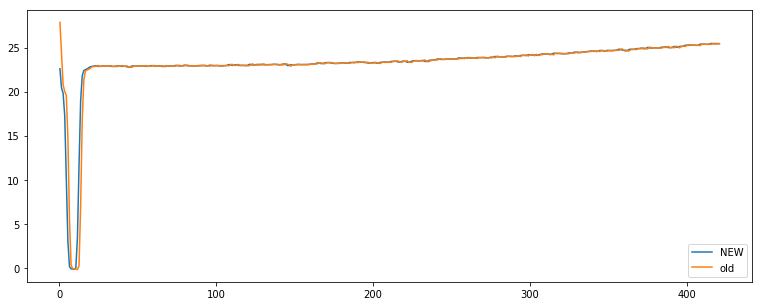

In [426]:
fig = plt.figure(figsize=(13,5))
plt.plot(index,np.interp(index,index-1.5,temps),label='NEW')
plt.plot(index,temps,label = 'old')
plt.legend()

In [333]:
can = all4[all4.columns[:-2]].iloc[:5]
for i in can.index:
#     print can.loc[i]
    can.loc[i] = c15(can.loc[i])

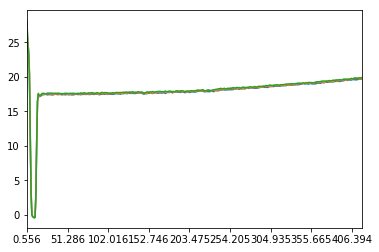

In [343]:
can.iloc[0][:-4].plot()
can.iloc[1][:-4].plot()
can.iloc[2][:-4].plot()

In [386]:
testal4 = all4.copy()
testal4 = testal4[testal4.columns[:-2]]
for i in testal4.index:
    testal4.loc[i] = c15(testal4.loc[i])

In [362]:
#Make a copy of old all4
oall4 = all4.copy()
testal4['hrs'] = all4['hrs']
testal4['Hin'] = all4['Hin']

In [392]:
def c15(ps):
    filt = ps
    temps= filt.values
    index= filt.index.values.astype(float)
    in5 = index - 1.5
    nt = np.interp(index,in5,temps)
    return nt

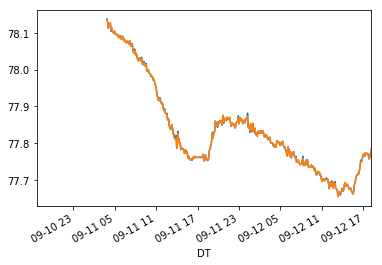

In [427]:
all3.Hin.plot()
all4.Hin.plot()

In [301]:
#Try to remove outlier
all3 = all3[all3[all3.columns[4]] <40]

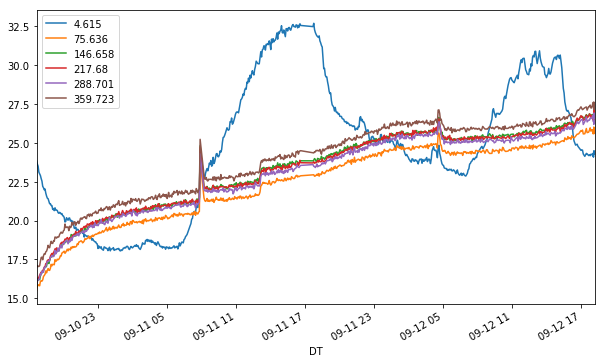

In [302]:
all3[all3.columns[4::70]].plot(figsize=(10,6))

In [341]:
import matplotlib.pyplot as plt

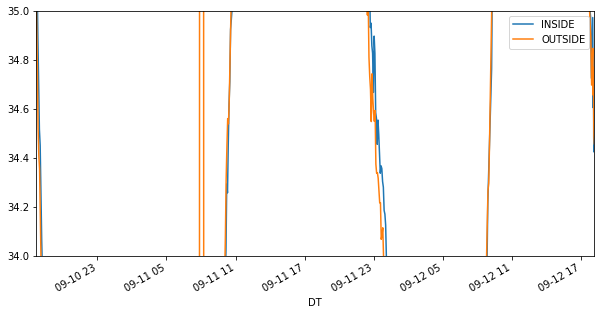

In [352]:
all3[all3.columns[0]].plot(figsize=(10,5),label='INSIDE')
all4[all4.columns[0]].plot(label='OUTSIDE')
plt.ylim(34,35)
plt.legend()

In [314]:
all3.to_csv('C3proc.csv')
all4.to_csv('C4proc.csv')

In [11]:
all3 = pd.read_csv('C3proc.csv',index_col=0)
all4 = pd.read_csv('C4proc.csv',index_col=0)

In [13]:
AL = all3[all3['hrs']>14]

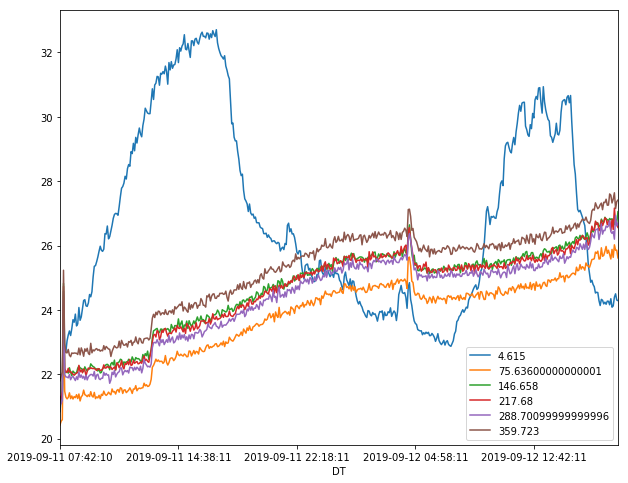

In [14]:
AL[AL.columns[4::70]].plot(figsize=(10,8))

In [15]:
all3.columns[5::60]

Index([u'5.629', u'66.505', u'127.381', u'188.25599999999997', u'249.132',
       u'310.008', u'370.88300000000004'],
      dtype='object')

In [439]:
all3.hrs.head(5)

DT
2019-09-10 17:42:10    0.036111
2019-09-10 17:46:11    0.103056
2019-09-10 17:50:11    0.169722
2019-09-10 17:54:11    0.236389
2019-09-10 17:58:11    0.303056
Name: hrs, dtype: float64

In [17]:
Hongshan Guoall4.hrs.head(5)

DT
2019-09-10 17:43:11    0.053056
2019-09-10 17:47:11    0.119722
2019-09-10 17:51:11    0.186389
2019-09-10 17:55:11    0.253056
2019-09-10 17:59:11    0.319722
Name: hrs, dtype: float64

Let's switch gear a little bit - to avoid the iteration problem, don't try to hard with the time steps since they simply aren't consistent. Let's try to only use the hours beyond 10 and get the mean values of all3 and all4, and then we can do the calculation easy.

In [429]:
al3_10=all3[all3['hrs']>10]
al4_10=all4[Hongshan Guoall4['hrs']>10]

In [430]:
al3a = al3_10.mean()
al4a = al4_10.mean()

In [431]:
al3_10.describe()

,0.556,1.571,2.586,3.6,4.615,5.629,6.644,7.659,8.673,9.688,...,415.526,416.54,417.555,418.569,419.584,420.599,421.613,422.628,hrs,Hin
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,...,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,533.000000
mean,35.672442,32.871864,29.408050,27.697653,26.104438,21.979418,11.291905,2.916494,1.704414,1.480946,...,27.142703,27.113847,27.052705,26.788619,26.728869,26.815226,115.574453,99.615905,28.769899,77.842520
std,4.827778,4.803532,4.584531,4.394425,4.136619,3.319240,2.191450,1.800673,1.820689,1.811225,...,2.497562,2.501552,2.495219,2.487855,2.487007,2.494709,25.200799,22.294792,11.114072,0.122058
min,26.858000,23.982000,20.743000,19.248000,18.154000,16.048000,8.004000,0.938000,-0.245000,-0.362000,...,23.418000,23.368000,23.351000,23.022000,23.033000,23.076000,82.851000,70.174000,10.036111,77.659232
25%,32.636750,29.843000,26.759500,25.331250,23.907250,20.265000,10.161500,1.984750,0.506250,0.297250,...,25.281500,25.251000,25.212750,24.955000,24.916250,24.971250,96.679250,83.131250,18.953056,77.759229
50%,35.047500,32.168000,28.699000,26.950500,25.461500,21.704000,11.316500,2.975000,1.833000,1.641500,...,27.862500,27.801500,27.779500,27.485000,27.382500,27.499000,108.896000,93.851500,28.869722,77.817455
75%,40.086000,37.187750,33.213750,31.235500,29.338250,24.204250,12.325750,3.388250,2.301250,2.073000,...,28.343750,28.277500,28.241750,27.971500,27.920750,27.993000,144.184000,125.306750,37.786389,77.872000
max,55.454000,52.672000,49.517000,47.790000,45.919000,41.231000,29.868000,21.246000,20.091000,19.909000,...,48.570000,48.565000,48.470000,48.109000,48.021000,48.239000,206.913000,181.287000,48.484444,78.138135


In [615]:
vT = (al3a-al4a).iloc[:-6]

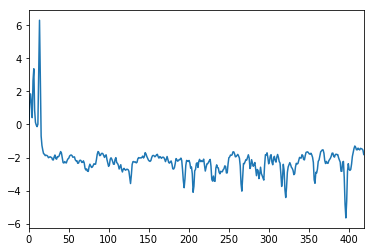

In [616]:
vT.plot()

So we have the temperature differencial here... Or so I think. The only problem now is how to advance this into the thermal conductivity. I believe we have a rough idea. This involves using the following relationship:


$$4\pi\sum^N_{i=1} k_{s,i}m_i l_i = \sum^N_{i=1}q_i = \sum^N_{i=1}\frac{\delta T_i}{R_i} = \frac{\sum^N_{i=1}(T_{an,i}-T_{b,i})}{R_g+R_{conv}+R_{cond}} = Q$$ 

This shoud apply to any given time step.

Now here are some known parameters: 

$k_g = 2.77 W/m\cdot K$

$k_{ep} = 22.5 W/m\cdot K$

$d_{eo} = 0.1651 m = 2r_b$

$Len = 408.43 m$

$R_g = \frac{ln(\frac{d_{eo}+ 0.004)}{d_{eo}})}{2\pi k_g}$ + $\frac{ln(\frac{d_{eo})}{d_{ei}})}{2\pi k_{ep}}$ + $\frac{1}{\pi d_{ei}h_{po}}$

_If necessary: This could also be calculated for any flow rate_

We now mostly just want to convert testv.py to something that we can easily get the hpo and Rg out of using any given deo, dei, Len and flow rates. This should be easy. The next step would therefore be casually converting the strin series with their index values (depths) into what we already know to be correct... 

It's important to stress this again: **$m$ is the gradient of temperature over natural log of time in hours**.

In [25]:
import numpy as np

In [154]:
def mfdf10(df):
#     df = df[df['hrs']>10]
#     all3[all3['hrs']>10]
    tar = df.set_index('hrs')
    tcol= tar.columns[:-1]
    dt = pd.DataFrame(columns = tcol)
    for i in tcol:
        dt[i]= np.gradient(tar.iloc[:-1][i],np.log(tar.iloc[:-1].index.values.astype(float)))
    return dt
def mmf(df):
    mdf = mfdf10(df)
    return mdf.mean()

In [446]:
msms = mfdf10(all3)

In [459]:
def gtG(df):
    DF = pd.DataFrame()
    for i in df.columns:
        DF[i]= np.gradient(df[i],np.log(df.index.values.astype(float)))
    return DF

In [473]:
gtG(all3[all3.columns[0:1]])

,0.556
0,6.441726e+05
1,-4.380924e+05
2,-1.372121e+06
3,-1.238176e+06
4,-8.363714e+05
5,-8.685776e+05
6,-1.271285e+06
7,-1.055227e+06
8,-1.114032e+06
9,-1.012757e+06


In [472]:
all3.head(3)

,0.556,1.571,2.586,3.6,4.615,5.629,6.644,7.659,8.673,9.688,...,415.526,416.54,417.555,418.569,419.584,420.599,421.613,422.628,hrs,Hin
DT,,,,,,,,,,,,,,,,,,,,,
2019-09-10 17:42:10,35.028,31.922,27.816,25.583,23.846,20.057,9.562,1.082,-0.043,-0.307,...,18.213,18.340,18.194,17.978,18.067,18.243,150.779,130.645,0.036111,NaN
2019-09-10 17:46:11,35.127,31.705,27.450,25.423,23.639,19.904,9.626,1.196,-0.108,-0.308,...,18.616,18.664,18.624,18.343,18.234,18.192,151.299,131.039,0.103056,NaN
2019-09-10 17:50:11,34.895,31.502,27.240,25.110,23.501,19.754,9.465,1.134,-0.171,-0.273,...,18.684,18.681,18.634,18.292,18.328,18.456,151.537,131.232,0.169722,NaN


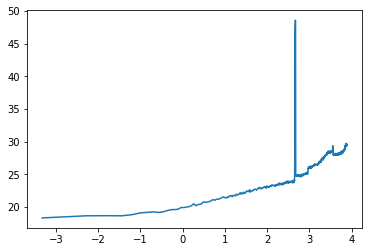

In [489]:
plt.plot(np.log(all3.hrs),all3[all3.columns[410]])

In [492]:
gt = all3[all3.columns[410]]

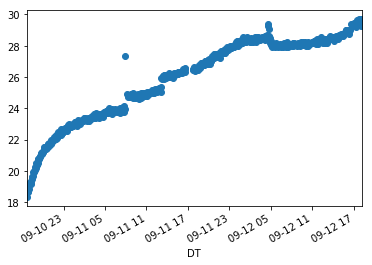

In [501]:
gt[gt<45].plot(marker = 'o',linestyle='')

In [502]:
from sklearn.linear_model import LinearRegression

In [504]:
linear_re = LinearRegression()
X = np.log(all3.hrs).values.reshape(-1,1)
Y = all3[all3.columns[410]].values.reshape(-1,1)
linear_re.fit(X,Y)
Y_pred = linear_re.predict(X)

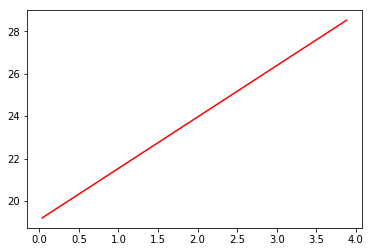

In [512]:
# plt.scatter(X,Y)
plt.plot(X[X>0].reshape(-1,1),linear_re.predict(X[X>0].reshape(-1,1)),color='red')

In [520]:
(linear_re.predict(X[X>0].reshape(-1,1))[-1]- linear_re.predict(X[X>0].reshape(-1,1))[0])/(X[X>0][-1]-X[X>0][0])

array([2.42308515])

In [523]:
linear_re.coef_

array([[2.42308515]])

In [587]:
def getMMS(df):
    sr = np.array([])
    X = np.log(df.hrs.values).reshape(-1,1)
    for i in range(len(df.columns)-3):
        lnr = LinearRegression()
#         X = np.log(all3.hrs).values.reshape(-1,1)
        Y = df[df.columns[i]].values.reshape(-1,1)
        lnr.fit(X,Y)
#         try:
#             print lnr.coef_
#         except:
#             continue
        sr = np.append(sr,lnr.coef_[0][0])
    return sr

In [594]:
all4=all4[all4.hrs>10]

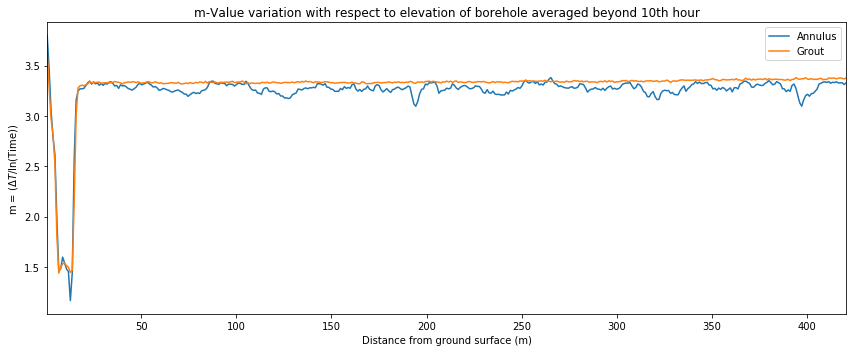

In [647]:
# len(getMMS(all3))
fig = plt.figure(figsize=(12,5))
plt.plot(all3.columns[:-4],getMMS(all3)[:-1],label='Annulus')
plt.plot(all4.columns[:-4],getMMS(all4)[:-1],label='Grout')

plt.ylabel('m = ($\Delta T$/ln(Time))')
plt.xlabel('Distance from ground surface (m)')
plt.title('m-Value variation with respect to elevation of borehole averaged beyond 10th hour')
plt.margins(x=0)
plt.legend()
plt.tight_layout()


plt.savefig('mvar.png',dpi = 250)

In [548]:
all3.head(2).hrs.values

array([0.03611111, 0.10305556])

In [571]:
all3.shape

(536, 419)

In [573]:
for i in range(419-4):
    all3 = all3[all3['hrs']>10]
    lnr = LinearRegression()
    X = np.log(all3.hrs).values.reshape(-1,1)
    Y = all3[all3.columns[i]].values.reshape(-1,1)
    try:
        print lnr.fit(X,Y).coef_
    except:
        continue

[[3.79714342]]
[[3.46857459]]
[[3.05378421]]
[[2.79181753]]
[[2.61579929]]
[[1.98008138]]
[[1.46387007]]
[[1.484154]]
[[1.59821788]]
[[1.54002436]]
[[1.48184265]]
[[1.45486666]]
[[1.16705583]]
[[1.44645829]]
[[2.57926881]]
[[3.15650778]]
[[3.24961379]]
[[3.26867535]]
[[3.26960325]]
[[3.27327029]]
[[3.30116458]]
[[3.3286423]]
[[3.3454342]]
[[3.31640231]]
[[3.33800073]]
[[3.3185119]]
[[3.32799828]]
[[3.30534686]]
[[3.3208717]]
[[3.30395923]]
[[3.32241717]]
[[3.3154374]]
[[3.33459816]]
[[3.3398507]]
[[3.32357508]]
[[3.29648629]]
[[3.30295318]]
[[3.27367964]]
[[3.30902773]]
[[3.29816599]]
[[3.30102603]]
[[3.28799291]]
[[3.27201056]]
[[3.26497954]]
[[3.25602516]]
[[3.27043427]]
[[3.28345621]]
[[3.31231449]]
[[3.32288679]]
[[3.30925022]]
[[3.31662072]]
[[3.32565553]]
[[3.3342801]]
[[3.31675662]]
[[3.30565819]]
[[3.28678724]]
[[3.2919113]]
[[3.27806465]]
[[3.25396299]]
[[3.25990245]]
[[3.27279307]]
[[3.26895469]]
[[3.26000831]]
[[3.25460102]]
[[3.24192837]]
[[3.2366752]]
[[3.24669803]]
[[3.25

Text(0.5,1,'m-Value variation with respect to elevations')

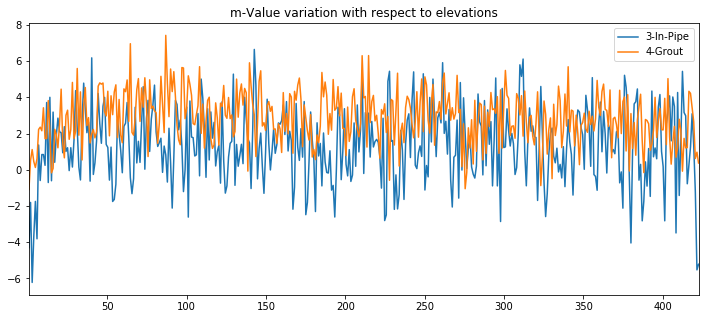

In [434]:
mmf(all3).plot(label='3-Annulus',figsize=(12,5))
mmf(all4).plot(label='4-Grout')
plt.legend()
plt.title('m-Value variation with respect to elevations')

In [404]:
all3.columns

Index([  0.556,   1.571,   2.586,     3.6,   4.615,   5.629,   6.644,   7.659,
         8.673,   9.688,
       ...
       415.526,  416.54, 417.555, 418.569, 419.584, 420.599, 421.613, 422.628,
        u'hrs',  u'Hin'],
      dtype='object', length=419)

Now just write a program that takes mi, li ? vT to generate ks.

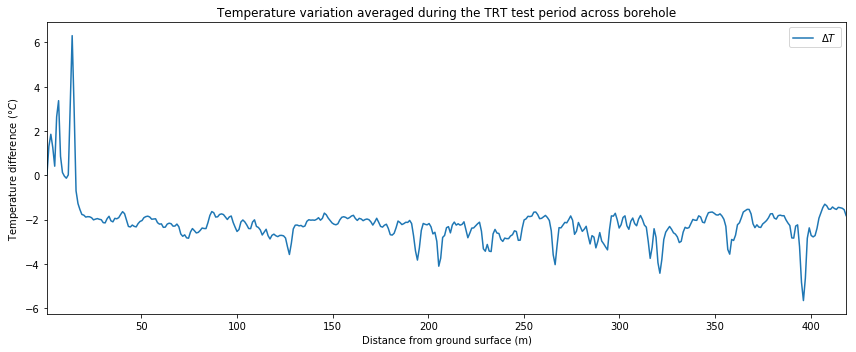

In [645]:
vT.plot(figsize=(12,5),label='$\Delta T$')
plt.xlabel('Distance from ground surface (m)')
plt.ylabel('Temperature difference ($\degree C$)')
plt.legend()
plt.title('Temperature variation averaged during the TRT test period across borehole')
plt.tight_layout()


plt.savefig('delTave.png',dpi = 250)

In [405]:
ta3 = all3.transpose()
ta4 = all4.transpose()
tt4 = testal4.transpose()

In [406]:
ta3.columns[10],ta3.columns[650],ta4.columns[650],tt4.columns[650]

(Timestamp('2019-09-10 18:22:11'),
 Timestamp('2019-09-12 15:34:11'),
 Timestamp('2019-09-12 15:11:10'),
 Timestamp('2019-09-12 15:11:10'))

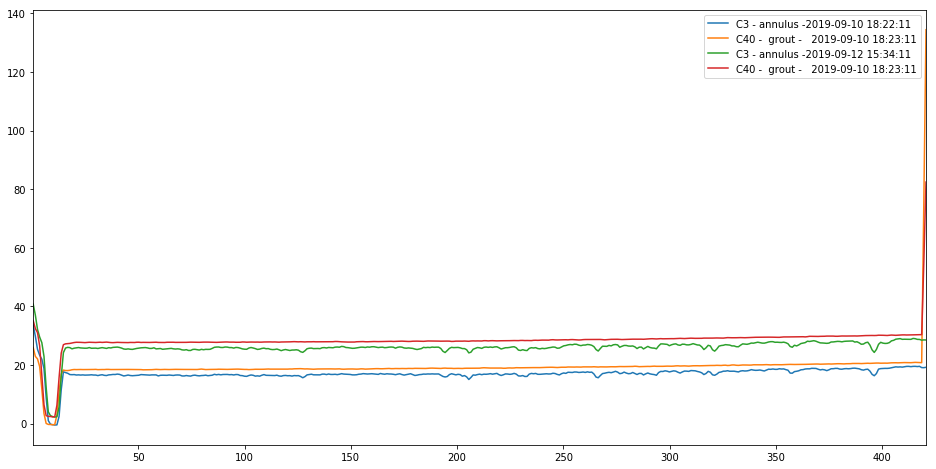

In [408]:
ta3[ta3.columns[10]][:-4].plot(label='C3 - annulus -'  + str(ta3.columns[10]))
# tt4[tt4.columns[10]][:-4].plot(label='C4 -  grout -   '    + tt4.columns[10])
ta4[ta4.columns[10]][:-4].plot(label='C40 -  grout -   '    + str(ta4.columns[10]))

ta3[ta3.columns[650]][:-4].plot(label='C3 - annulus -' + str(ta3.columns[650]),figsize=(16,8))
# tt4[tt4.columns[650]][:-4].plot(label='C4 -  grout -   '+ tt4.columns[650])
ta4[ta4.columns[650]][:-4].plot(label='C40 -  grout -   '    + str(ta4.columns[10]))


plt.legend()

In [179]:
import testv as tv

In [180]:
tv.cbhe().Rg

0.015338707676900707

In [181]:
import testv as tv
def gks(dt,m,li):
    rb = tv.cbhe().Rg #Rg = 0.015 
    return dt/rb/4/np.pi/m/li

In [188]:
DIS0 = all3.columns.values[:-2].astype(float)

In [410]:
np.mean(gks(vT,mmf(all3),np.append(1e-5,np.diff(all3.columns.values[:-2].astype(float)))))

-1961.334364537548

In [630]:
len(vT)

413

In [631]:
len(getMMS(all3)[:-3])

413

In [632]:
len(np.append(1e-5,np.diff(all3.columns.values[:-2].astype(float))))

417

In [634]:
kss = gks(vT,getMMS(all3)[:-3],np.append(1e-5,np.diff(all3.columns.values[:-2].astype(float)))[:-4])

In [635]:
kss = kss[kss<15]
kss = kss[kss>-30]

In [636]:
inst = kss.index.values.astype(float)
inst = ['%.3f' % elem for elem in inst]

In [637]:
kss.index = inst

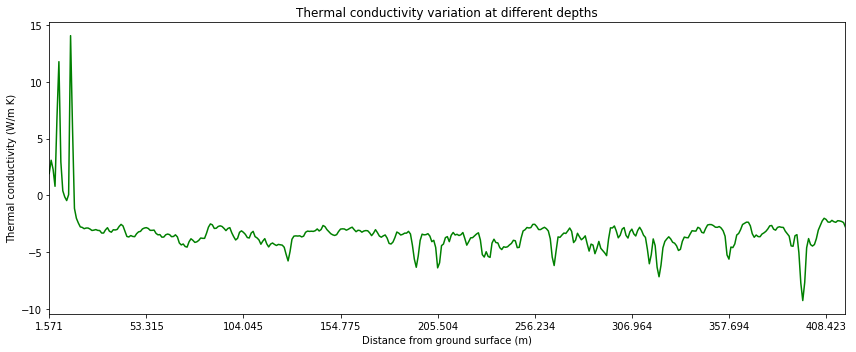

In [644]:
kss.plot(figsize=(12,5),label='$k_s$',color='g')
plt.xlabel('Distance from ground surface (m)')
plt.ylabel('Thermal conductivity (W/m K)')
plt.title('Thermal conductivity variation at different depths')
plt.tight_layout()
plt.savefig('ks.png',dpi = 250)

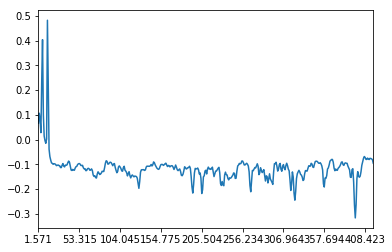

In [652]:
alss = kss/2.515e6*24*3600
alss.plot()

In [656]:
len(kss)

411

In [655]:
len(getMMS(all3)[:-1])

415

In [679]:
qss = (kss*4*np.pi*getMMS(all3)[:-5])*1.015

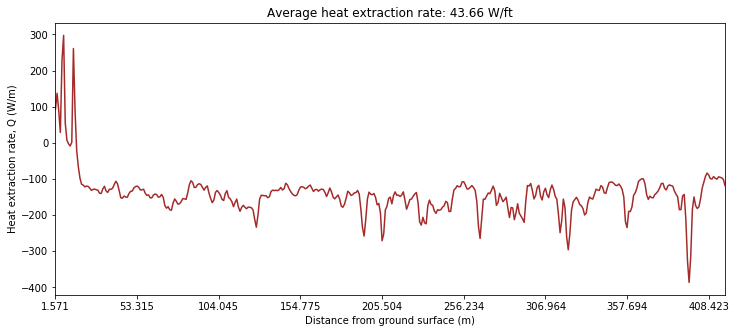

In [684]:
qss.plot(figsize=(12,5),color='brown')
plt.xlabel('Distance from ground surface (m)')
plt.ylabel('Heat extraction rate, Q (W/m)')
plt.title('Average heat extraction rate: 43.66 W/ft')
plt.savefig('qss.png',dpi=250)

In [683]:
qss.sum()/1340

-43.65925366342087

In [653]:
alss.mean()

-0.1156548399743855

In [639]:
kss.mean()

-3.366573177495132

In [242]:
len(kss)

386

In [239]:
np.mean(all3.mean() - all4.mean())

-2.1882770473664004

In [241]:
gks(-2.18,3.28,420.8)*420.8

-3.44813304895317

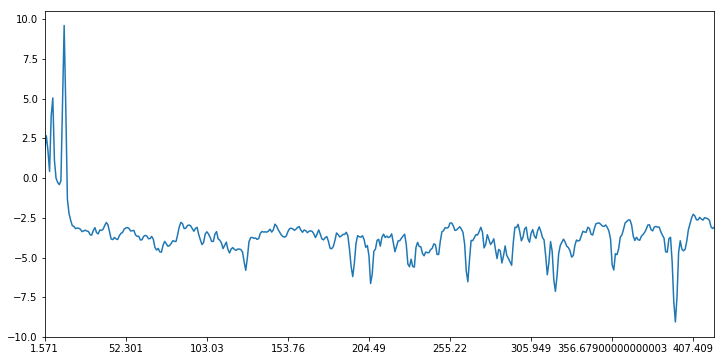

In [248]:
gks(vT,3.28,np.append(1e-5,np.diff(all3.columns.values[:-2].astype(float)))[:-2])[1:].plot(figsize=(12,6))

In [251]:
ks_s = gks(vT,3.28,np.append(1e-5,np.diff(all3.columns.values[:-2].astype(float)))[:-2])[1:]

In [254]:
ist = ks_s.index.values.astype(float)
ist = ['%.3f' % elem for elem in ist]
ks_s.index = ist

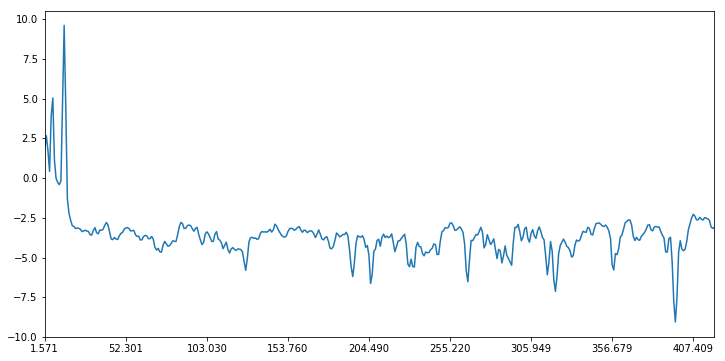

In [255]:
ks_s.plot(figsize=(12,6))

In [649]:
alss = kss/2.515e6

In [253]:
alss.mean()

-1.4363589673464433e-06

In [220]:
kss.sum()

-1900.916224414187

In [151]:
mmf(al3_10).mean()

2.8156005559148056

In [152]:
mmf(al4_10).mean()

2.8639498280637845

In [85]:
tar = al3_10inhr.transpose()

In [120]:
tar.columns

Float64Index([10.0361111111, 10.1030555556, 10.1697222222, 10.2363888889,
              10.3027777778, 10.3697222222, 10.4363888889, 10.5030555556,
              10.5697222222, 10.6363888889,
              ...
              48.1697222222, 48.2361111111, 48.3508333333, 48.3677777778,
              48.3844444444, 48.4011111111, 48.4177777778, 48.4344444444,
              48.4511111111, 48.4844444444],
             dtype='float64', name=u'hrs', length=532)

In [119]:
Hongshan Guotar.index.values[:-1].astype(float)

array([  0.556,   1.571,   2.586,   3.6  ,   4.615,   5.629,   6.644,
         7.659,   8.673,   9.688,  10.702,  11.717,  12.731,  13.746,
        14.761,  15.775,  16.79 ,  17.804,  18.819,  19.834,  20.848,
        21.863,  22.877,  23.892,  24.907,  25.921,  26.936,  27.95 ,
        28.965,  29.98 ,  30.994,  32.009,  33.023,  34.038,  35.053,
        36.067,  37.082,  38.096,  39.111,  40.126,  41.14 ,  42.155,
        43.169,  44.184,  45.199,  46.213,  47.228,  48.242,  49.257,
        50.271,  51.286,  52.301,  53.315,  54.33 ,  55.344,  56.359,
        57.374,  58.388,  59.403,  60.417,  61.432,  62.447,  63.461,
        64.476,  65.49 ,  66.505,  67.52 ,  68.534,  69.549,  70.563,
        71.578,  72.593,  73.607,  74.622,  75.636,  76.651,  77.666,
        78.68 ,  79.695,  80.709,  81.724,  82.739,  83.753,  84.768,
        85.782,  86.797,  87.812,  88.826,  89.841,  90.855,  91.87 ,
        92.884,  93.899,  94.914,  95.928,  96.943,  97.957,  98.972,
        99.987, 101.

In [121]:
tar.head(5)

hrs,10.0361111111,10.1030555556,10.1697222222,10.2363888889,10.3027777778,10.3697222222,10.4363888889,10.5030555556,10.5697222222,10.6363888889,...,48.1697222222,48.2361111111,48.3508333333,48.3677777778,48.3844444444,48.4011111111,48.4177777778,48.4344444444,48.4511111111,48.4844444444
0.556,27.206,27.145,27.162,27.145,27.160,27.252,27.235,27.038,27.244,27.231,...,34.973,34.725,34.973,34.738,34.605,34.748,34.766,34.487,34.424,34.717
1.571,24.361,24.441,24.368,24.276,24.361,24.446,24.363,24.294,24.323,24.288,...,31.581,31.476,31.253,31.793,31.235,31.462,31.586,31.400,31.146,31.315
2.5860000000000003,21.131,21.191,21.047,21.124,21.131,21.160,21.027,21.062,21.110,20.960,...,27.735,27.608,27.601,27.429,27.412,27.454,27.769,27.705,27.242,27.672
3.6,19.846,19.629,19.562,19.678,19.638,19.686,19.601,19.561,19.622,19.633,...,25.729,25.705,25.803,25.675,25.596,25.510,26.049,25.788,25.832,25.646
4.615,18.589,18.684,18.592,18.580,18.484,18.570,18.398,18.510,18.634,18.535,...,24.272,24.268,24.159,24.347,24.084,24.123,24.395,24.499,24.305,24.288


In [115]:
def mfbh10(df):
    dfinhr = df.set_index('hrs')
    dfT = dfinhr.transpose()
    dft = dfT.drop('Hin')
#     dft['hr'] = dft.index.values.astype(float)
    print np.gradient(dft.mean(),np.log(dft.index.values.astype(float)))
    return dft

In [81]:
warrant = mfbh10(al3_10).index.valuesGuo

In [82]:
np.array(map(float,warrant))

ValueError: could not convert string to float: Hin

In [ ]:
Guograd1 = np.gradient(al3_10)

In [101]:
df = pd.read_csv(f23[0],header=25,sep='\t')
df.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True

In [115]:
DF = df[df['depth']>0]
DF = DF.set_index('depth')
DF = DF.transpose()

In [118]:
DF.append(DF.loc['tempc'])

depth,0.556,1.571,2.586,3.6,4.615,5.629,6.644,7.659,8.673,9.688,...,413.496,414.511,415.526,416.54,417.555,418.569,419.584,420.599,421.613,422.628
tempc,35.028,31.922,27.816,25.583,23.846,20.057,9.562,1.082,-0.043,-0.307,...,18.426,18.397,18.213,18.340,18.194,17.978,18.067,18.243,150.779,130.645
stokes,1511.683,1482.592,1417.013,1330.393,1282.809,1224.095,1132.814,1086.536,1080.632,1077.299,...,798.622,798.540,798.468,797.638,797.397,796.318,795.635,795.057,1355.958,1437.682
nonstokes,1326.245,1279.463,1195.928,1108.970,1058.872,988.736,859.212,780.507,770.431,766.641,...,616.650,616.426,615.654,615.416,614.651,612.991,612.728,612.861,1779.870,1779.996
tempc,35.028,31.922,27.816,25.583,23.846,20.057,9.562,1.082,-0.043,-0.307,...,18.426,18.397,18.213,18.340,18.194,17.978,18.067,18.243,150.779,130.645


In [72]:
f24 = fl[3]
all4 = pd.DataFrame(index=pd.read_csv(f24[1],header=25,sep='\t')['length (m)'].values)

for i in range(len(f24)):
    fram = pd.read_csv(f24[i],header=25,sep='\t')
    fram.set_axis(['depth','tempc','stokes','nonstokes'],axis=1,inplace=True)
    all4[str(f24[i])[-25:-25+8]+str(f24[i])[-25+9:-25+15]]=fram.tempc.values

In [74]:
C3 = all3[all3.index.values > 0]
C4 = all4[all4.index.values > 0]

ins = C3.index.to_list()
import pickle
with open('ins','wb') as f:
    pickle.dump(ins,f)

In [85]:
C3.index.values.to_csv('Depthprof.csv')

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [78]:
C3.columns[0]

'20190910174210'

In [79]:
C4.columns[0]

'20190910174311'

In [34]:
s1[7:16]

'channel 1'

In [35]:
M = fl[0]

In [38]:
import bisect
M[bisect.bisect_left(M, 'pt0919/channel 1/2019/sep/channel 1 20190910 155211 00001.ddf')]

'pt0919/channel 1/2019/sep/channel 1 20190910 155211 00001.ddf'

In [40]:
M[bisect.bisect_right(M, 'pt0919/channel 1/2019/sep/channel 1 20190910 155211 00001.ddf'):]

['pt0919/channel 1/2019/sep/channel 1 20190910 155611 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 160011 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 160411 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 160811 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 161211 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 161611 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 162011 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 162411 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 162811 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 163211 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 163611 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 164011 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 164411 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 164811 00001.ddf',
 'pt0919/channel 1/2019/sep/channel 1 20190910 165211 00001.ddf',
 'pt0919/c